In [1]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

# Matplotlib for visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns

sns.set(font_scale = 2)

# Imputing missing values
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn import tree


In [2]:
# Read in data into dataframes
train_features = pd.read_csv('data/train_features.csv')
test_features = pd.read_csv('data/test_featuers.csv')
train_labels = pd.read_csv('data/train_labels.csv')
test_labels = pd.read_csv('data/test_labels.csv')

train_features = train_features.drop(train_features.columns[[0]], axis=1)
test_features = test_features.drop(test_features.columns[[0]], axis=1)
train_labels = train_labels.drop(train_labels.columns[[0]], axis=1)
test_labels = test_labels.drop(test_labels.columns[[0]], axis=1)


Заново создадим финальную модель.

In [3]:
# Create an imputer object with a median filling strategy
imputer = SimpleImputer(strategy='median')

# Train on the training features
imputer.fit(train_features)

# Transform both training data and testing data
X = imputer.transform(train_features)
X_test = imputer.transform(test_features)

# Sklearn wants the labels as one-dimensional vectors
y = np.array(train_labels).reshape((-1,))
y_test = np.array(test_labels).reshape((-1,))

In [4]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

In [5]:
model = RandomForestRegressor(criterion='friedman_mse', max_depth=15,
                              min_samples_split=5, min_samples_leaf=1,
                              n_estimators=600, max_features=1.0,
                              random_state=42)

model.fit(X, y)

RandomForestRegressor(criterion='friedman_mse', max_depth=15,
                      min_samples_split=5, n_estimators=600, random_state=42)

In [6]:
#  Make predictions on the test set
model_pred = model.predict(X_test)

print('Final Model Performance on the test set: MAE = %0.4f' % mae(y_test, model_pred))

Final Model Performance on the test set: MAE = 65286.7876


Найдём наиболее важные для модели признаки, и проверим каким будет результат после избавление от остальных.

In [ ]:
# Extract the feature importances into a dataframe
feature_results = pd.DataFrame({'feature': list(train_features.columns),
                                'importance': model.feature_importances_})

# Show the top 10 most important
feature_results = feature_results.sort_values('importance', ascending = False).reset_index(drop=True)

feature_results.head(10)

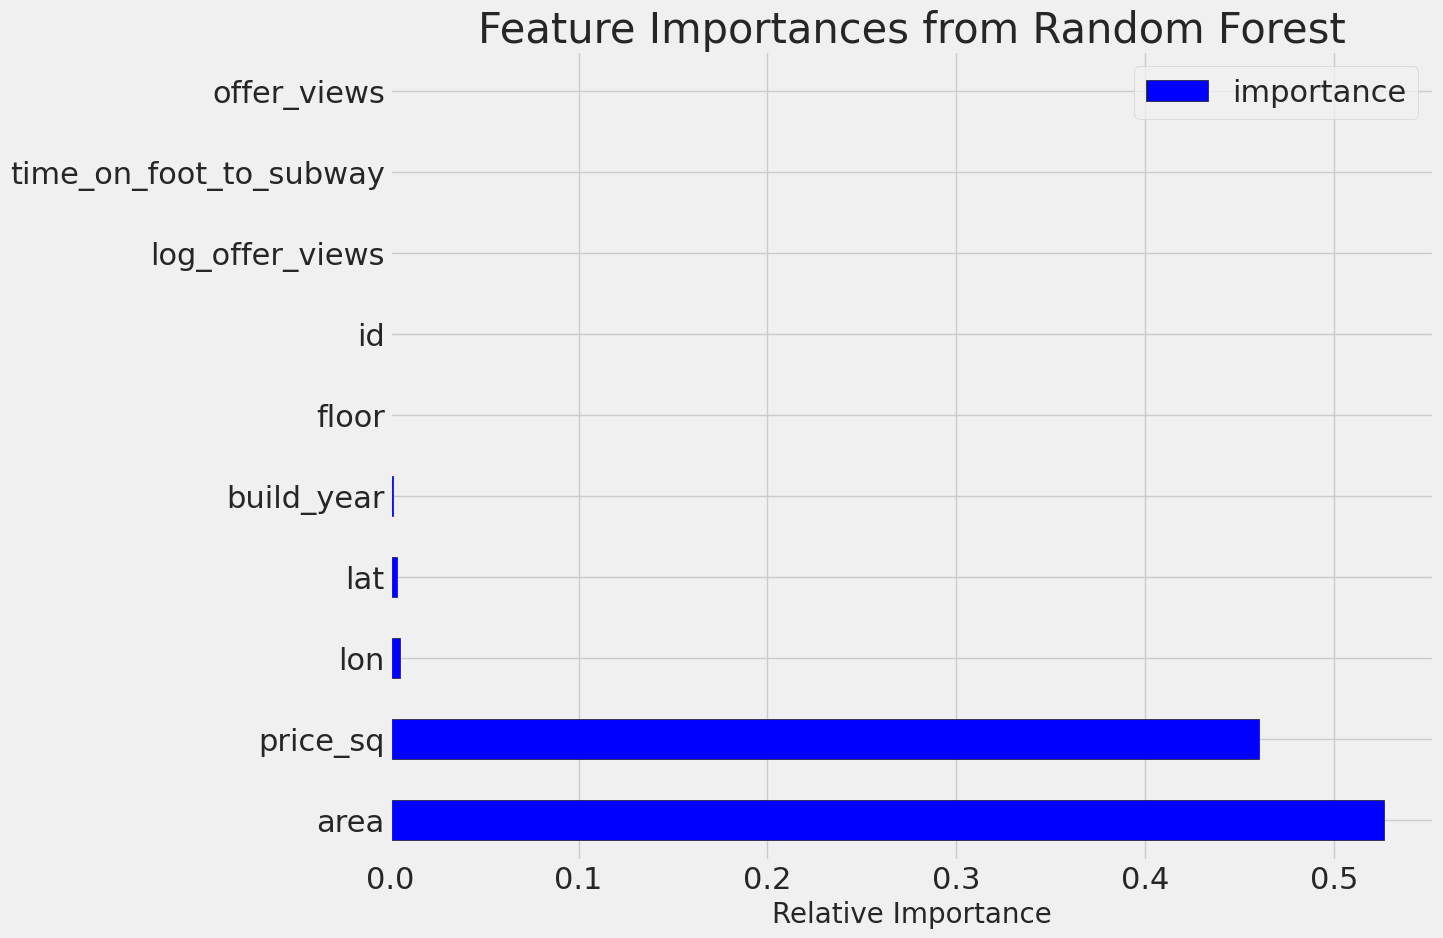

In [9]:
figsize(12, 10)
plt.style.use('fivethirtyeight')

# Plot the 10 most important features in a horizontal bar chart
feature_results.loc[:9, :].plot(x = 'feature', y = 'importance',
                                 edgecolor = 'k',
                                 kind='barh', color = 'blue');
plt.xlabel('Relative Importance', size = 20); plt.ylabel('')
plt.title('Feature Importances from Random Forest', size = 30);

In [12]:
# Extract the names of the most important features
most_important_features = feature_results['feature'][:10]

# Find the index that corresponds to each feature name
indices = [list(train_features.columns).index(x) for x in most_important_features]

# Keep only the most important features
X_reduced = X[:, indices]
X_test_reduced = X_test[:, indices]

print('Most important training features shape: ', X_reduced.shape)
print('Most important testing  features shape: ', X_test_reduced.shape)

Most important training features shape:  (5607, 10)
Most important testing  features shape:  (2403, 10)


In [13]:
# Create the model with the same hyperparamters
model_reduced = RandomForestRegressor(criterion='friedman_mse', max_depth=15,
                              min_samples_split=5, min_samples_leaf=1,
                              n_estimators=600, max_features=1.0,
                              random_state=42)

# Fit and test on the reduced set of features
model_reduced.fit(X_reduced, y)
model_reduced_pred = model_reduced.predict(X_test_reduced)

print('RandomForestRegressor Results: MAE = %0.4f' % mae(y_test, model_reduced_pred))

RandomForestRegressor Results: MAE = 63350.7514


Значение модели слегка улучшились (почти 2000) с уменьшеным набором признаков, поэтому дальше будем уменьшенный набор признаков.

Теперь сохранним финальную модель, SimpleImputer объект и датафрейм с названиями признаков и типом данных для дальнейшего использования с помощью модуля pickle.

In [14]:
import pickle

# save the model, imputer, features columns data as a pickle file
model_pkl_file = "pkl/model.pkl"
imputer_pkl_file = "pkl/imputer.pkl"
features_pkl_file = "pkl/features.pkl"

feature_names = pd.DataFrame({'feature': list(train_features.columns), 'dtype': list(train_features.dtypes)})
final_model = model_reduced

with open(model_pkl_file, 'wb') as file:
    pickle.dump(final_model, file)

with open(imputer_pkl_file, 'wb') as file:
    pickle.dump(imputer, file)

with open(features_pkl_file, 'wb') as file:
    pickle.dump(feature_names, file)